In [2]:
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
from dlm import *
import dlm
import importlib

plt.rcParams['figure.figsize'] = (20,6)

## Generate noisy sinusoid data

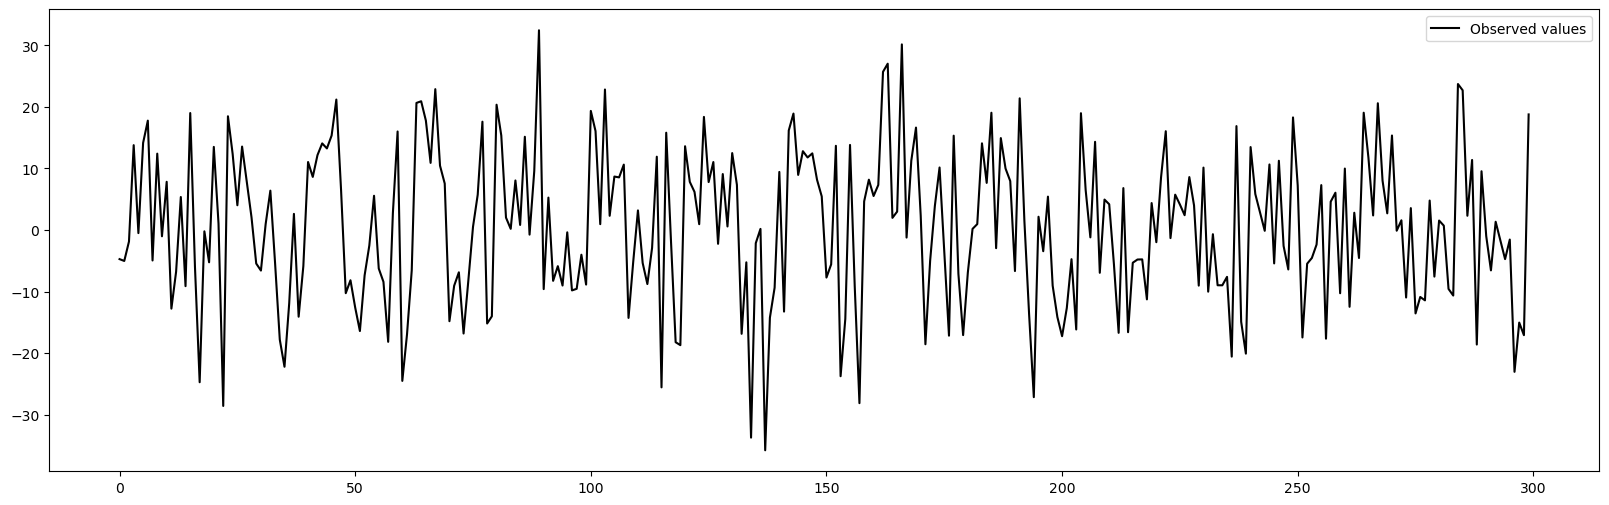

In [3]:
T1 = 20

X = np.array(range(300))
#y = 5.0*np.cos(2*np.pi*x/T1)+5.0*np.sin(2*np.pi*x/T2)
mu = 10.0*np.sin(2*np.pi*X/T1)    ##Latent mean value evolving as a senoid in time
Y = mu+rd.normal(0,10.0, X.size)  ##Addition of white noise, mean and standard-deviation
#plt.plot(mu, color="r", lw=2.0, label="Latent mean value")  
plt.plot(Y, color="k", label="Observed values")
plt.legend()


## Investigate hidden period through periodogram

Periodo a ser usado =  20


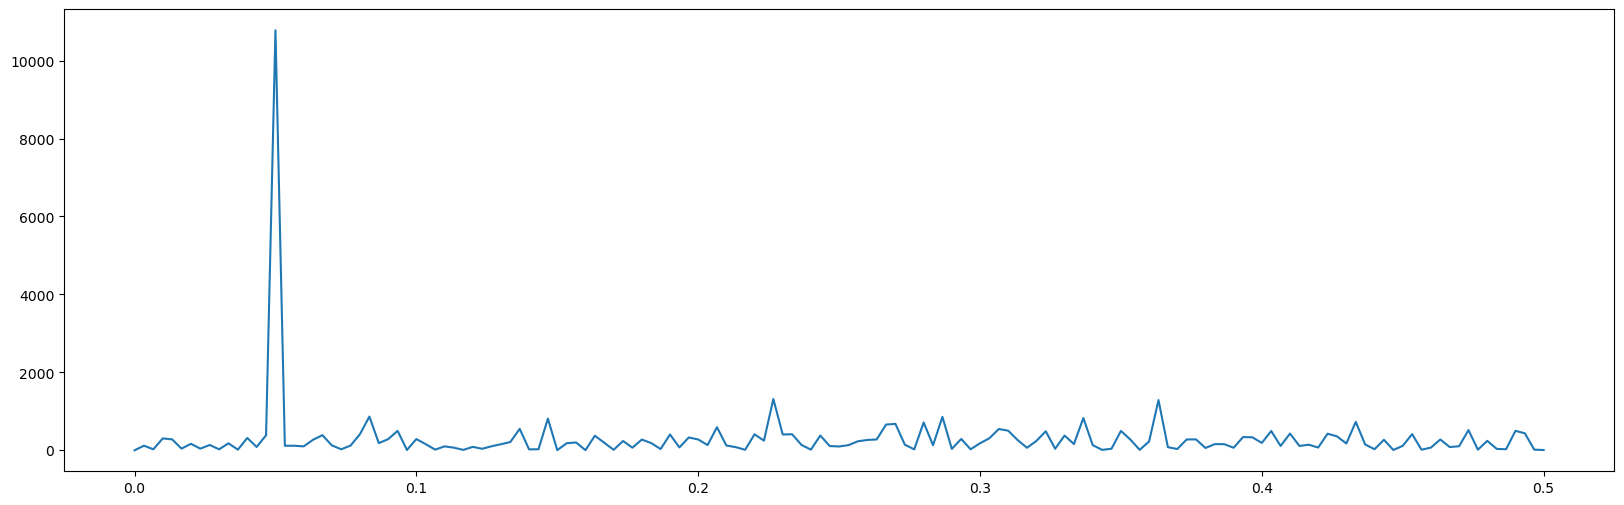

In [4]:
from scipy.signal import periodogram

base_T = []

##for i in acel_data:
frequencies, power = periodogram(Y)

plt.plot(frequencies, power)

ind = np.argmax(power)
max_power_freq = frequencies[ind]

    ##print("Indice = ", ind)
    ##print("Frequencia = ", max_power_freq)
    ##print("Periodo = ", 1/max_power_freq)

T_found = int(np.round(1/max_power_freq))    ##Identify period of series
    
##    base_T.append(T)                 ##Save period

print("Periodo a ser usado = ", T_found)

## Apply Mixture of Fourier DLMs Online

In [21]:
##APLICA DLM
#importlib.reload(dlm)

##Parâmetros iniciais do filtro
n0 = 1    ##Prior number of degrees of freedom
S0 = 100.0 ##Prior observation variance
T_min = 1
T_max = 100
d1 = 1.0   ##FAtor de desconto do nível da série
d2 = 0.999   ##FAtor de desconto dos harmônicos
h = 2     ##Número de harmônicos
n_component_dlms = 1000
param_size = 2+2*h    ##Número de parâmetros
Ts = np.linspace(T_min,T_max,n_component_dlms)

print("List of periods = ", Ts)

m0, C0 = 0.0*np.ones(param_size), 1.0e6*np.eye(param_size)

my_mix_dlm = dlm.mixture_Fourier_DLM(m0,C0,n0,S0,T_min,T_max,n_component_dlms,h,d1,d2)

forecasts = []
f_variances = []
probs = []

for t in range(Y.shape[0]):
    
    ##Forecast y
    f, f_var = my_mix_dlm.one_step_forecast()
    forecasts.append(f)
    f_variances.append(f_var)
        
    ##Take current observation
    #y = Y[t]
    y = Y[t:t+1]    ##Notice y is an array with a single element
    
    ##Update state
    p = my_mix_dlm.update_state(y)
    probs.append(p)
    
probs = np.array(probs)
forecasts = np.array(forecasts)
f_variances = np.array(f_variances)

List of periods =  [  1.           1.0990991    1.1981982    1.2972973    1.3963964
   1.4954955    1.59459459   1.69369369   1.79279279   1.89189189
   1.99099099   2.09009009   2.18918919   2.28828829   2.38738739
   2.48648649   2.58558559   2.68468468   2.78378378   2.88288288
   2.98198198   3.08108108   3.18018018   3.27927928   3.37837838
   3.47747748   3.57657658   3.67567568   3.77477477   3.87387387
   3.97297297   4.07207207   4.17117117   4.27027027   4.36936937
   4.46846847   4.56756757   4.66666667   4.76576577   4.86486486
   4.96396396   5.06306306   5.16216216   5.26126126   5.36036036
   5.45945946   5.55855856   5.65765766   5.75675676   5.85585586
   5.95495495   6.05405405   6.15315315   6.25225225   6.35135135
   6.45045045   6.54954955   6.64864865   6.74774775   6.84684685
   6.94594595   7.04504505   7.14414414   7.24324324   7.34234234
   7.44144144   7.54054054   7.63963964   7.73873874   7.83783784
   7.93693694   8.03603604   8.13513514   8.23423423   8.3

In [22]:
##Computa erro médio quadrático da previsão
MSE = np.mean((Y[-100:]-forecasts[-100:])**2)

print("MSE = ", MSE)

MSE =  106.32118575044571


Período final =  40.34234234234234


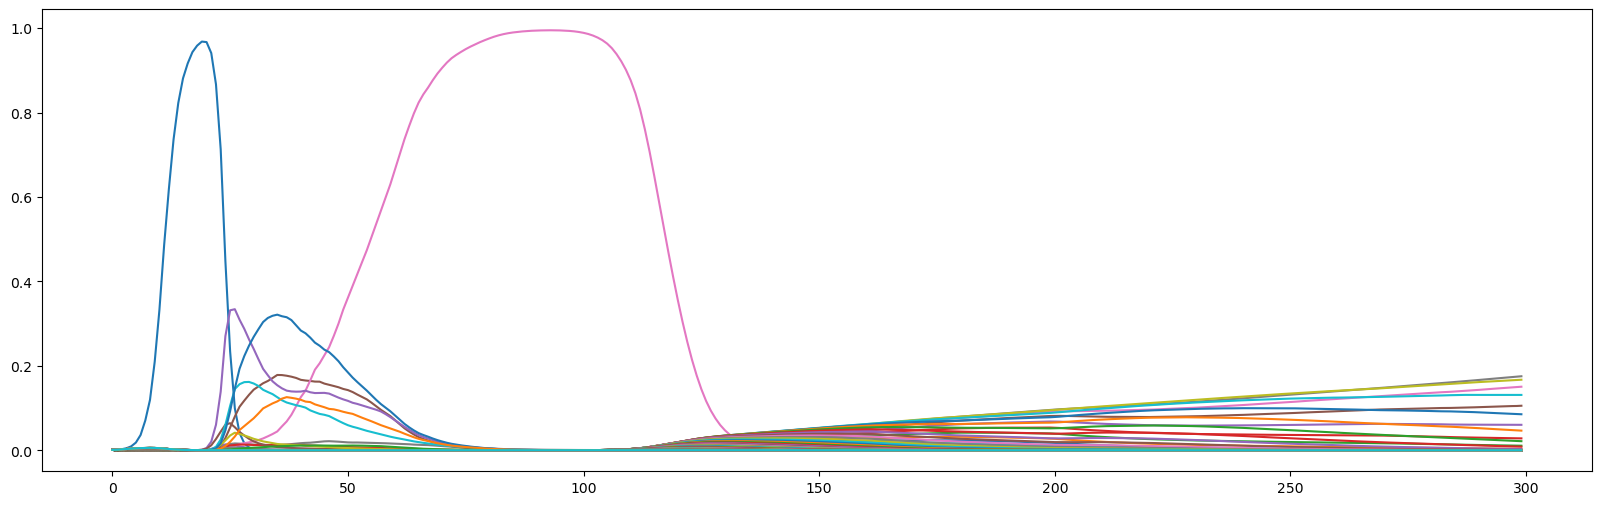

In [23]:
plt.plot(probs)
ind = np.argmax(probs[-1,:])
print("Período final = ", Ts[ind])

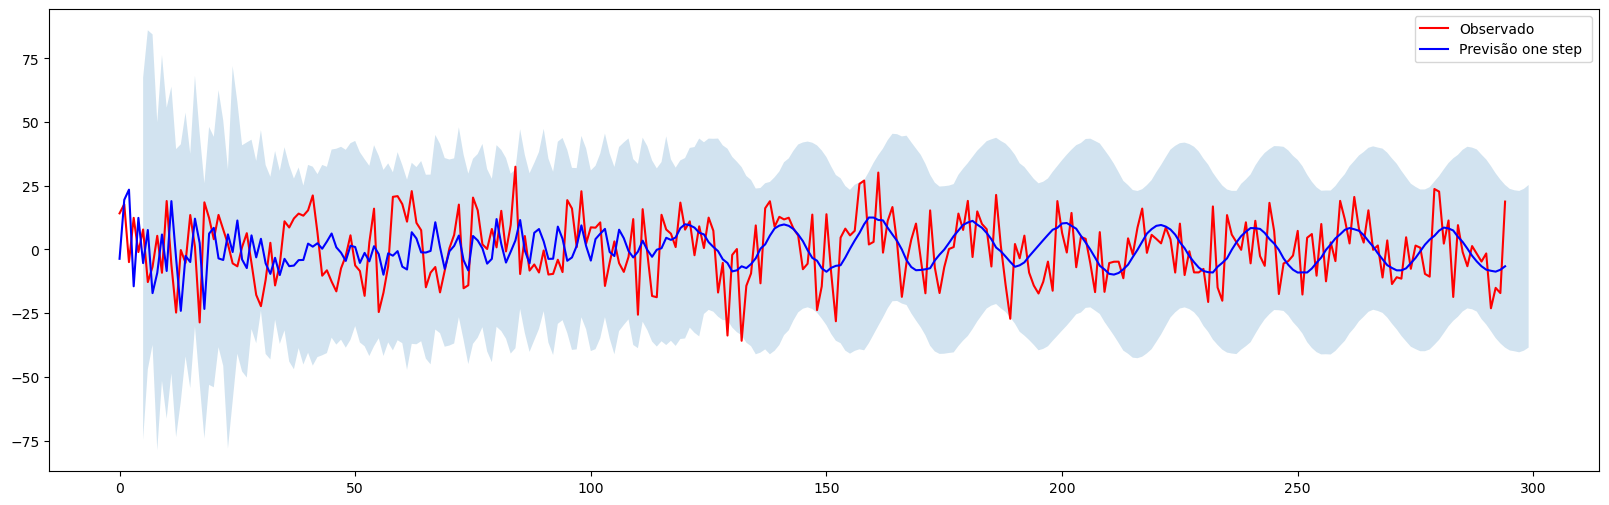

In [24]:
#plt.figure(1)
#plt.plot(Y[5:], '-', color='k', label="Observed")
#plt.plot(forecasts[5:],'-', lw=2.0, color='red', label="One step forecast")
#plt.legend()

slic = slice(5, len(Y))    ##Take last 500 observations in the time series

n_sigmas = 3    ##3 sigmas = approx 99% confidence
sup_lim = forecasts[slic]+n_sigmas*np.sqrt(f_variances)[slic]
inf_lim = forecasts[slic]-n_sigmas*np.sqrt(f_variances)[slic]

#x = dados.index[slic]

fig, ax = plt.subplots()
ax.plot(Y[slic], '-', color='red', label="Observado")
ax.plot(forecasts[slic],'-', color='blue', label="Previsão one step ")
ax.fill_between(X[slic], inf_lim, sup_lim, alpha=0.2)
##plt.plot(y, '-', color='red', label="Observado")
##plt.plot(forecasts,'-', color='blue', label="Previsão one step ")
ax.legend()

## Standard-deviation of forecast

Final standard-deviation = 10.630801123111649


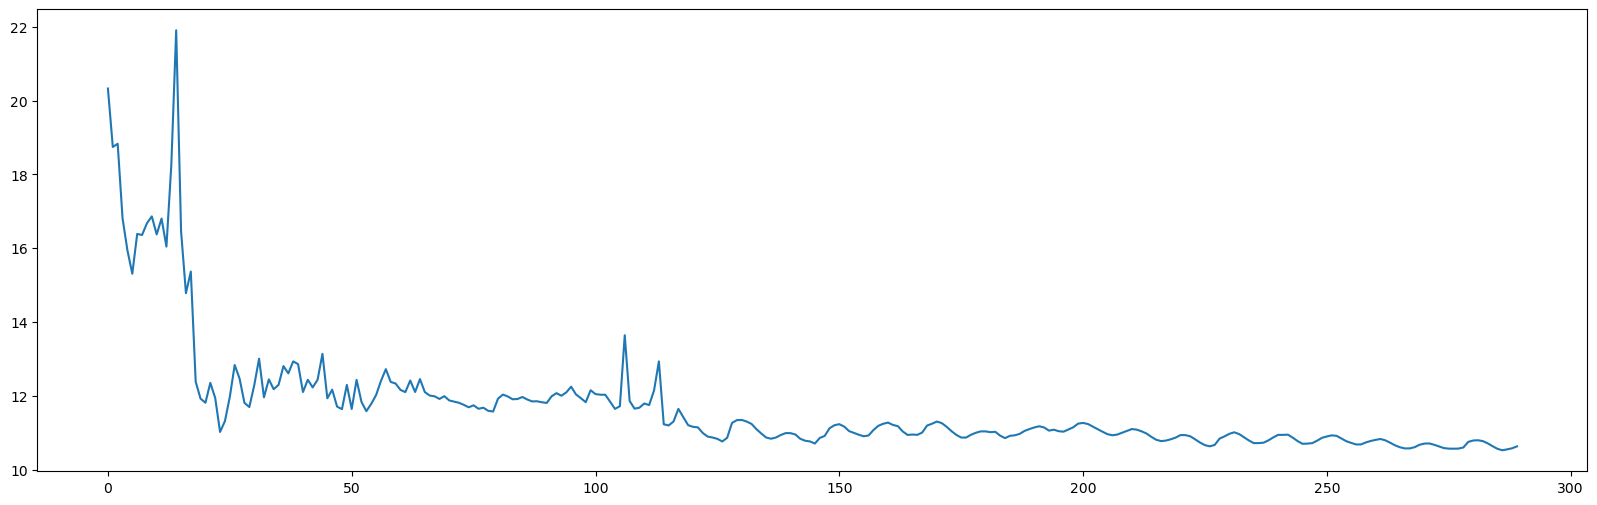

In [25]:
std = np.sqrt(f_variances)
plt.plot(std[10:])
print("Final standard-deviation =", std[-1])